In [1]:
# Import the emulator class.
from emantis.halo_mass_function import HMFEmulator

from colossus.cosmology import cosmology
from colossus.lss import mass_function, peaks
import MiraTitanHMFemulator

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import copy

In [2]:
# Make plots prettier.
plt.rcParams.update({'font.size': 16})
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
plt.rc('xtick', direction='in')
plt.rc('ytick', direction='in')

## HMF fits & emulators

### $w$CDM

In [3]:
aexp_list = np.array([0.4, 0.5, 0.6667, 1])
z_list = 1/aexp_list - 1

deltas_list = ['fof', 200]

# Read cosmo. parameters.
cosmo_params_planck18 = {
        "Omega_m": 0.3071,
        "Omega_b": 0.048446,
        "h": 0.6803,
        "n_s": 0.96641,
        "sigma8": 0.822,
        "w": -1.0
    }

print(cosmo_params_planck18)

{'Omega_m': 0.3071, 'Omega_b': 0.048446, 'h': 0.6803, 'n_s': 0.96641, 'sigma8': 0.822, 'w': -1.0}


In [4]:
# Init. e-MANTIS emulator.
emu_hmf = {}
for delta in deltas_list:
    if delta == 'fof':
        emu_hmf[delta] = HMFEmulator(model = "wCDM", mass_def="b0.2", use_resolution_correction=True, n_jobs=8)    
    else:
        emu_hmf[delta] = HMFEmulator(model = "wCDM", mass_def=f"{delta}c", use_resolution_correction=True, n_jobs=8)

In [5]:
# Init. Mira-Titan emulator.
MiraTitanEmu = MiraTitanHMFemulator.Emulator()

In [6]:
fits_names = {
            'tinker08': [200, 500],
            'crocce10': ['fof'],
            'bhattacharya11': ['fof'],
            'courtin11': ['fof'],
            'angulo12': ['fof'],
            'watson13': ['fof'],
            'despali16': [200, 500],
            'bocquet16': [200, 500],
             }

#### Compare all predictions to emantis

In [7]:
ncolor = 10
cmap=plt.get_cmap(f'tab{ncolor}')

nbins_per_decade = 10

for deltac in deltas_list:

    fig, axes = plt.subplots(len(z_list), 1, gridspec_kw={'hspace': 0, 'wspace':0}, sharex="all", sharey="all", figsize=(6,6))

    for i,z in enumerate(z_list):
    
        massmin = emu_hmf[deltac].range("mass_halo", aexp=aexp_list[i])[0]
        massmax = emu_hmf[deltac].range("mass_halo", aexp=aexp_list[i])[1]
        nbins = int(np.round(np.log10(massmax/massmin)*nbins_per_decade))
        bins = np.geomspace(massmin, massmax, nbins)

        axes[i].fill_between(bins, -5, 5, color='dimgray', alpha=0.5)
        axes[i].fill_between(bins, -10, 10, color='dimgray', alpha=0.3)
        
        emantis_hmf, emantis_std = emu_hmf[deltac].predict_hmf(bins, cosmo_params_planck18, aexp_list[i], True)
    
        params_colossus = {'flat': True,
                  'H0': cosmo_params_planck18["h"]*100,
                  'Om0': cosmo_params_planck18["Omega_m"],
                  'Ob0': cosmo_params_planck18["Omega_b"],
                  'sigma8': cosmo_params_planck18["sigma8"],
                  'ns': cosmo_params_planck18["n_s"],
                  'w0': cosmo_params_planck18["w"]}
        cosmo = cosmology.setCosmology('myCosmo', **params_colossus)

        c = 0
        for k,name in enumerate(fits_names):
            if deltac in fits_names[name]:
                #print(name)
                if deltac == 'fof':
                    mdef = 'fof'
                else:
                    mdef = f'{deltac}c'

                # Maximum redshift for crocce10.
                if (name == 'crocce10') and (z>1):
                    axes[i].plot(np.NaN, np.NaN, '-', color=cmap(c%ncolor), label=name)
                    c += 1
                    continue
                    
                # Maximum redshift for courtin11.
                if (name == 'courtin11') and (z>0):
                    axes[i].plot(np.NaN, np.NaN, '-', color=cmap(c%ncolor), label=name)
                    c += 1
                    continue

                # Maximum redshift for angulo12.
                if (name == 'angulo12') and (z>0):
                    axes[i].plot(np.NaN, np.NaN, '-', color=cmap(c%ncolor), label=name)
                    c += 1
                    continue

                # Maximum redshift for bocquet16.
                if (name == 'bocquet16') and (z>0):
                    axes[i].plot(np.NaN, np.NaN, '-', color=cmap(c%ncolor), label=name)
                    c += 1
                    continue

                # Use DMO version of bocquet16.
                if name == 'bocquet16':
                    hmf_fit = mass_function.massFunction(bins, z, mdef = mdef, model = name, q_out = 'dndlnM', hydro=False)
                else:    
                    hmf_fit = mass_function.massFunction(bins, z, mdef = mdef, model = name, q_out = 'dndlnM')

                # Compute and plot relative difference with respect to e-MANTIS.
                relativ_err_fit = (hmf_fit - emantis_hmf)/emantis_hmf
                axes[i].plot(bins, relativ_err_fit*100, '-', color=cmap(c%ncolor), label=name)
            c += 1
        

        if deltac == 200:
            params_mt = {'Ommh2': cosmo_params_planck18["Omega_m"]*cosmo_params_planck18["h"]**2,
                'Ombh2': cosmo_params_planck18["Omega_b"]*cosmo_params_planck18["h"]**2,
                'Omnuh2': 0,
                'n_s': cosmo_params_planck18["n_s"],
                'h': cosmo_params_planck18["h"],
                'w_0': cosmo_params_planck18["w"],
                'w_a': 0,
                'sigma_8': cosmo_params_planck18["sigma8"]}
            hmf_mt = MiraTitanEmu.predict(params_mt, z, bins)[0][0] 
            relativ_err_mt = (hmf_mt - emantis_hmf)/emantis_hmf    
            axes[i].plot(bins, relativ_err_mt*100, '--', color=cmap(c+1%ncolor), label='MiraTitan')
        
        textstr = '\n'.join((
        f'$z={z:.2f}$',))
        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='white', alpha=1)
        # place a text box in top left in axes coords
        axes[i].text(0.05, 0.75, textstr, transform=axes[i].transAxes, fontsize=11,
        verticalalignment='bottom', bbox=props)

    axes[-1].set_xlabel(r'$M_{h} \ \left[h^{-1}M_\odot\right]$')
    fig.text(0, 0.5, r'$\epsilon_\mathrm{others,emu} \left[\%\right]$', va='center', rotation='vertical')
    
    axes[-1].set_xscale('log')
    
    axes[-1].set_ylim((-40, 40))

    axes[0].legend(fontsize=10)

    if deltac == 'fof':
        axes[0].set_title(r'P18$\quad | \quad$FoF, $b = 0.2$')
        plt.tight_layout()

    else:
        axes[0].set_title(fr'P18$\quad | \quad$SO, $\Delta = {deltac}\mathrm{{c}}$')
        plt.tight_layout()
    
    plt.show()

e-MANTIS:hmf:b0.2:aexp_0.4 Training the emulator...
e-MANTIS:hmf:b0.2:aexp_0.4 ...training completed.
e-MANTIS:hmf:b0.2:aexp_0.5 Training the emulator...
e-MANTIS:hmf:b0.2:aexp_0.5 ...training completed.
e-MANTIS:hmf:b0.2:aexp_0.6667 Training the emulator...
e-MANTIS:hmf:b0.2:aexp_0.6667 ...training completed.
e-MANTIS:hmf:b0.2:aexp_1.0 Training the emulator...
e-MANTIS:hmf:b0.2:aexp_1.0 ...training completed.


RuntimeError: Failed to process string with tex because latex could not be found

Error in callback <function _draw_all_if_interactive at 0x7f62ff2c3ce0> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 600x600 with 4 Axes>

#### Varying $w$

##### FOF

In [8]:
w_list = [-1.5, -1.3, -0.7, -0.5]
fits_names = ['crocce10', 'bhattacharya11', 'watson13']
lns = {
    'bhattacharya11': '--',
    'watson13': '+',
    'crocce10': '-.'
}

Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.


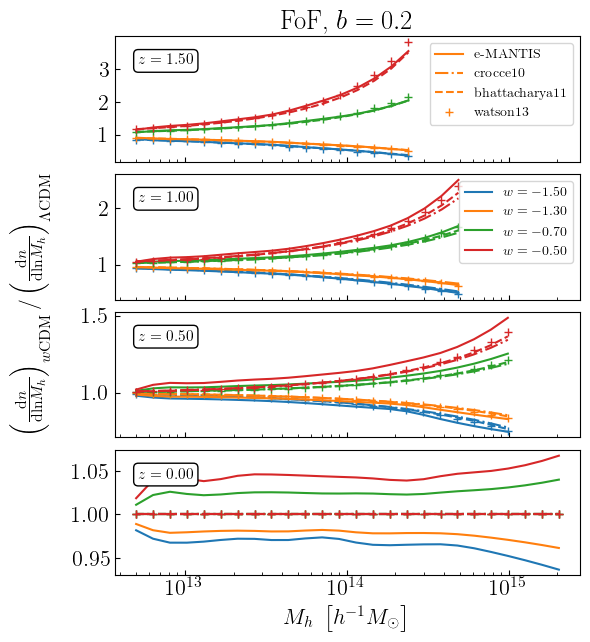

In [9]:
ncolor = 10
cmap=plt.get_cmap(f'tab{ncolor}')

nbins_per_decade = 10

deltac = 'fof'

fig, axes = plt.subplots(len(z_list), 1, gridspec_kw={'hspace': 0.1, 'wspace':0}, sharex="all", sharey=False, figsize=(6,7))

for i,z in enumerate(z_list):

    massmin = emu_hmf[deltac].range("mass_halo", aexp=aexp_list[i])[0]
    massmax = emu_hmf[deltac].range("mass_halo", aexp=aexp_list[i])[1]
    nbins = int(np.round(np.log10(massmax/massmin)*nbins_per_decade))
    bins = np.geomspace(massmin, massmax, nbins)

    emantis_hmf_ref, emantis_std_ref = emu_hmf[deltac].predict_hmf(bins, cosmo_params_planck18, aexp_list[i], True)

    params_colossus = {'flat': True,
                        'H0': cosmo_params_planck18["h"]*100,
                        'Om0': cosmo_params_planck18["Omega_m"],
                        'Ob0': cosmo_params_planck18["Omega_b"],
                        'sigma8': cosmo_params_planck18["sigma8"],
                        'ns': cosmo_params_planck18["n_s"],
                        'w0': cosmo_params_planck18["w"],
                        'de_model': 'w0'
                      }
    cosmo = cosmology.setCosmology('myCosmo', **params_colossus)

    hmf_fit_ref = {}
    for name in fits_names:
            mdef = 'fof'
            hmf_fit_ref[name] = mass_function.massFunction(bins, z, mdef = mdef, model = name, q_out = 'dndlnM')

    for j,w in enumerate(w_list):
        params_emantis = copy.deepcopy(cosmo_params_planck18)
        params_emantis["w"] = w
    
        emantis_hmf, emantis_std = emu_hmf[deltac].predict_hmf(bins, params_emantis, aexp_list[i], True)
        
        if i == 1:
            axes[i].plot(bins, emantis_hmf / emantis_hmf_ref, '-', color=cmap(j%ncolor), label=fr'$w={w:.2f}$')
        elif (i == 0) and (j == 1):
            axes[i].plot(bins, emantis_hmf / emantis_hmf_ref, '-', color=cmap(j%ncolor), label=fr'e-MANTIS')
        else:
            axes[i].plot(bins, emantis_hmf / emantis_hmf_ref, '-', color=cmap(j%ncolor))

        cosmo.w0 = w
        cosmo.checkForChangedCosmology()

        for name in fits_names:
            # Maximum redshift for crocce10.
            if (name == 'crocce10') and (z>1):
                if (i == 0) and (j == 1):
                    axes[i].plot(np.NaN, np.NaN, lns[name], color=cmap(j%ncolor), label=name)
                continue
                
            mdef = 'fof'
            hmf_fit = mass_function.massFunction(bins, z, mdef = mdef, model = name, q_out = 'dndlnM')
            hmf_ratio = hmf_fit / hmf_fit_ref[name]

            if (i == 0) and (j == 1):
                axes[i].plot(bins, hmf_ratio, lns[name], color=cmap(j%ncolor), label=name)
            else:
                axes[i].plot(bins, hmf_ratio, lns[name], color=cmap(j%ncolor))
    
    textstr = '\n'.join((
    f'$z={z:.2f}$',))
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=1)
    # place a text box in top left in axes coords
    axes[i].text(0.05, 0.75, textstr, transform=axes[i].transAxes, fontsize=11,
    verticalalignment='bottom', bbox=props)
    
axes[-1].set_xlabel(r'$M_{h} \ \left[h^{-1}M_\odot\right]$')
fig.text(-0.05, 0.5, r'$\left(\frac{\mathrm{d}n}{\mathrm{dln}M_{h}}\right)_{w\mathrm{CDM}} / \left(\frac{\mathrm{d}n}{\mathrm{dln}M_{h}}\right)_{\Lambda\mathrm{CDM}}$', va='center', rotation='vertical')

axes[-1].set_xscale('log')

axes[0].legend(fontsize=10)
axes[1].legend(fontsize=10)

if deltac == 'fof':
    axes[0].set_title(r'FoF, $b = 0.2$')
    plt.tight_layout()
else:
    axes[0].set_title(fr'SO, $\Delta = {deltac}\mathrm{{c}}$')
    plt.tight_layout()

plt.show()

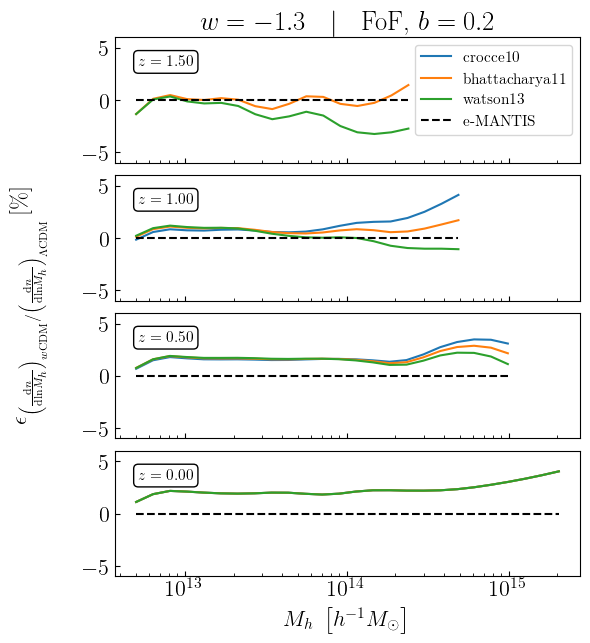

In [10]:
ncolor = 10
cmap=plt.get_cmap(f'tab{ncolor}')

nbins_per_decade = 10

deltac = 'fof'
w_value = -1.3

fig, axes = plt.subplots(len(z_list), 1, gridspec_kw={'hspace': 0.1, 'wspace':0}, sharex="all", sharey=True, figsize=(6,7))

for i,z in enumerate(z_list):

    massmin = emu_hmf[deltac].range("mass_halo", aexp=aexp_list[i])[0]
    massmax = emu_hmf[deltac].range("mass_halo", aexp=aexp_list[i])[1]
    nbins = int(np.round(np.log10(massmax/massmin)*nbins_per_decade))
    bins = np.geomspace(massmin, massmax, nbins)

    emantis_hmf_ref, emantis_std_ref = emu_hmf[deltac].predict_hmf(bins, cosmo_params_planck18, aexp_list[i], True)

    params_emantis_wcdm = copy.deepcopy(cosmo_params_planck18)
    params_emantis_wcdm["w"] = w_value
    emantis_hmf_wcdm, emantis_std_wcdm = emu_hmf[deltac].predict_hmf(bins, params_emantis_wcdm, aexp_list[i], True)

    emantis_boost = emantis_hmf_wcdm / emantis_hmf_ref

    params_colossus_lcdm = {'flat': True,
                        'H0': cosmo_params_planck18["h"]*100,
                        'Om0': cosmo_params_planck18["Omega_m"],
                        'Ob0': cosmo_params_planck18["Omega_b"],
                        'sigma8': cosmo_params_planck18["sigma8"],
                        'ns': cosmo_params_planck18["n_s"],
                        'w0': cosmo_params_planck18["w"],
                        'de_model': 'w0'
                      }

    params_colossus_wcdm = {'flat': True,
                        'H0': cosmo_params_planck18["h"]*100,
                        'Om0': cosmo_params_planck18["Omega_m"],
                        'Ob0': cosmo_params_planck18["Omega_b"],
                        'sigma8': cosmo_params_planck18["sigma8"],
                        'ns': cosmo_params_planck18["n_s"],
                        'w0': w_value,
                        'de_model': 'w0'
                      }

    hmf_fit_boost = {}
    c = 0
    for j,name in enumerate(fits_names):
            # Maximum redshift for crocce10.
            if (name == 'crocce10') and (z>1):
                axes[i].plot(np.NaN, np.NaN, '-', color=cmap(c%ncolor), label=name)
                c += 1
                continue
                
            mdef = 'fof'
            cosmo = cosmology.setCosmology('myCosmo', **params_colossus_lcdm)
            hmf_fit_lcdm = mass_function.massFunction(bins, z, mdef = mdef, model = name, q_out = 'dndlnM')
            cosmo = cosmology.setCosmology('myCosmo', **params_colossus_wcdm)
            hmf_fit_wcdm = mass_function.massFunction(bins, z, mdef = mdef, model = name, q_out = 'dndlnM')
            hmf_fit_boost[name] = hmf_fit_wcdm / hmf_fit_lcdm

            axes[i].plot(bins, (hmf_fit_boost[name] - emantis_boost) / emantis_boost * 100, color=cmap(c%ncolor), label=name)
            c += 1

    axes[i].plot(bins, [0 for elt in bins], '--k', label='e-MANTIS')
    
    textstr = '\n'.join((
    f'$z={z:.2f}$',))
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=1)
    # place a text box in top left in axes coords
    axes[i].text(0.05, 0.75, textstr, transform=axes[i].transAxes, fontsize=11,
    verticalalignment='bottom', bbox=props)
    
axes[-1].set_xlabel(r'$M_{h} \ \left[h^{-1}M_\odot\right]$')
fig.text(-0.05, 0.5, r'$\epsilon_{\left(\frac{\mathrm{d}n}{\mathrm{dln}M_{h}}\right)_{w\mathrm{CDM}} / \left(\frac{\mathrm{d}n}{\mathrm{dln}M_{h}}\right)_{\Lambda\mathrm{CDM}}} \left[\%\right]$', va='center', rotation='vertical')

axes[-1].set_xscale('log')

axes[-1].set_ylim((-6, 6))
axes[0].legend(fontsize=11)

if deltac == 'fof':
    axes[0].set_title(fr'$w={w_value} \quad | \quad$FoF, $b = 0.2$')
    plt.tight_layout()
else:
    axes[0].set_title(fr'$w={w_value} \quad | \quad$SO, $\Delta = {deltac}\mathrm{{c}}$')
    plt.tight_layout()

plt.show()

##### SOD

In [11]:
w_list = [-1.5, -1.3, -0.7, -0.5]
fits_names = ['tinker08', 'despali16']
lns = {
    'tinker08': '--',
    'despali16': '-.',
    'bocquet16': '+',
    'MiraTitan': 'd',
}

Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.


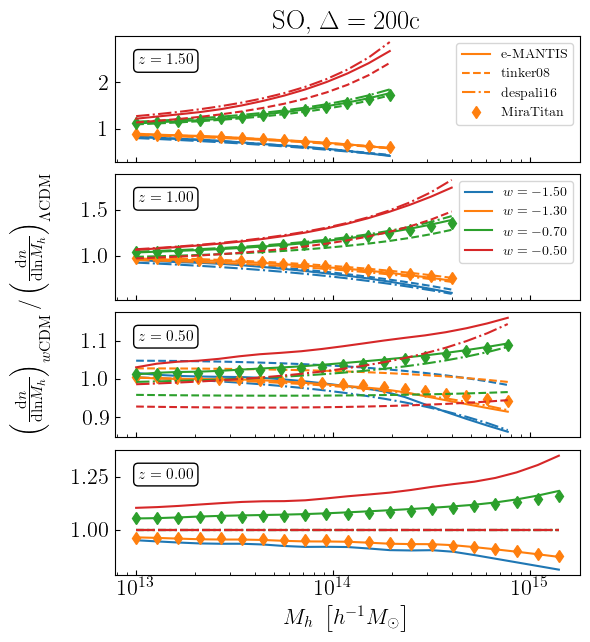

In [12]:
ncolor = 10
cmap=plt.get_cmap(f'tab{ncolor}')

nbins_per_decade = 10

deltac = 200

fig, axes = plt.subplots(len(z_list), 1, gridspec_kw={'hspace': 0.1, 'wspace':0}, sharex="all", sharey=False, figsize=(6,7))

for i,z in enumerate(z_list):

    massmin = emu_hmf[deltac].range("mass_halo", aexp=aexp_list[i])[0]
    massmax = emu_hmf[deltac].range("mass_halo", aexp=aexp_list[i])[1]
    nbins = int(np.round(np.log10(massmax/massmin)*nbins_per_decade))
    bins = np.geomspace(massmin, massmax, nbins)

    emantis_hmf_ref, emantis_std_ref = emu_hmf[deltac].predict_hmf(bins, cosmo_params_planck18, aexp_list[i], True)

    params_colossus = {'flat': True,
                        'H0': cosmo_params_planck18["h"]*100,
                        'Om0': cosmo_params_planck18["Omega_m"],
                        'Ob0': cosmo_params_planck18["Omega_b"],
                        'sigma8': cosmo_params_planck18["sigma8"],
                        'ns': cosmo_params_planck18["n_s"],
                        'w0': cosmo_params_planck18["w"],
                        'de_model': 'w0'
                      }
    cosmo = cosmology.setCosmology('myCosmo', **params_colossus)

    hmf_fit_ref = {}
    for name in fits_names:
            mdef = f'{deltac}c'
            # Use DMO version of bocquet16.
            if name == 'bocquet16':
                hmf_fit_ref[name] = mass_function.massFunction(bins, z, mdef = mdef, model = name, q_out = 'dndlnM', hydro=False)
            else:    
                hmf_fit_ref[name] = mass_function.massFunction(bins, z, mdef = mdef, model = name, q_out = 'dndlnM')

    if deltac == 200:
        params_mt_ref = {'Ommh2': cosmo_params_planck18["Omega_m"]*cosmo_params_planck18["h"]**2,
            'Ombh2': cosmo_params_planck18["Omega_b"]*cosmo_params_planck18["h"]**2,
            'Omnuh2': 0,
            'n_s': cosmo_params_planck18["n_s"],
            'h': cosmo_params_planck18["h"],
            'w_0': cosmo_params_planck18["w"],
            'w_a': 0,
            'sigma_8': cosmo_params_planck18["sigma8"]}
        hmf_mt_ref = MiraTitanEmu.predict(params_mt_ref, z, bins)[0][0] 

    for j,w in enumerate(w_list):
        params_emantis = copy.deepcopy(cosmo_params_planck18)
        params_emantis["w"] = w
    
        emantis_hmf, emantis_std = emu_hmf[deltac].predict_hmf(bins, params_emantis, aexp_list[i], True)

        if i == 1:
            axes[i].plot(bins, emantis_hmf / emantis_hmf_ref, '-', color=cmap(j%ncolor), label=fr'$w={w:.2f}$')
        elif (i == 0) and (j == 1):
            axes[i].plot(bins, emantis_hmf / emantis_hmf_ref, '-', color=cmap(j%ncolor), label=fr'e-MANTIS')
        else:
            axes[i].plot(bins, emantis_hmf / emantis_hmf_ref, '-', color=cmap(j%ncolor))

        cosmo.w0 = w
        cosmo.checkForChangedCosmology()

        for name in fits_names:
            mdef = f'{deltac}c'
            
            # Use DMO version of bocquet16.
            if name == 'bocquet16':
                hmf_fit = mass_function.massFunction(bins, z, mdef = mdef, model = name, q_out = 'dndlnM', hydro=False)
            else:    
                hmf_fit = mass_function.massFunction(bins, z, mdef = mdef, model = name, q_out = 'dndlnM')
                
            hmf_ratio = hmf_fit / hmf_fit_ref[name]

            if (i == 0) and (j == 1):
                axes[i].plot(bins, hmf_ratio, lns[name], color=cmap(j%ncolor), label=name)
            else:
                axes[i].plot(bins, hmf_ratio, lns[name], color=cmap(j%ncolor))
    
        if (deltac == 200) and (w >= -1.3) and (w <= -0.7):
            params_mt = {'Ommh2': cosmo_params_planck18["Omega_m"]*cosmo_params_planck18["h"]**2,
                'Ombh2': cosmo_params_planck18["Omega_b"]*cosmo_params_planck18["h"]**2,
                'Omnuh2': 0,
                'n_s': cosmo_params_planck18["n_s"],
                'h': cosmo_params_planck18["h"],
                'w_0': w,
                'w_a': 0,
                'sigma_8': cosmo_params_planck18["sigma8"]}
            hmf_mt = MiraTitanEmu.predict(params_mt, z, bins)[0][0] 

            if (i == 0) and (j == 1):
                axes[i].plot(bins, hmf_mt / hmf_mt_ref, lns['MiraTitan'], color=cmap(j%ncolor), label='MiraTitan')
            else:
                axes[i].plot(bins, hmf_mt / hmf_mt_ref, lns['MiraTitan'], color=cmap(j%ncolor))
                    
    textstr = '\n'.join((
    f'$z={z:.2f}$',))
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=1)
    # place a text box in top left in axes coords
    axes[i].text(0.05, 0.75, textstr, transform=axes[i].transAxes, fontsize=11,
    verticalalignment='bottom', bbox=props)
    
axes[-1].set_xlabel(r'$M_{h} \ \left[h^{-1}M_\odot\right]$')
fig.text(-0.05, 0.5, r'$\left(\frac{\mathrm{d}n}{\mathrm{dln}M_{h}}\right)_{w\mathrm{CDM}} / \left(\frac{\mathrm{d}n}{\mathrm{dln}M_{h}}\right)_{\Lambda\mathrm{CDM}}$', va='center', rotation='vertical')

axes[-1].set_xscale('log')

axes[0].legend(fontsize=10)
axes[1].legend(fontsize=10)

if deltac == 'fof':
    axes[0].set_title(r'FoF, $b = 0.2$')
    plt.tight_layout()
else:
    axes[0].set_title(fr'SO, $\Delta = {deltac}\mathrm{{c}}$')
    plt.tight_layout()

plt.show()

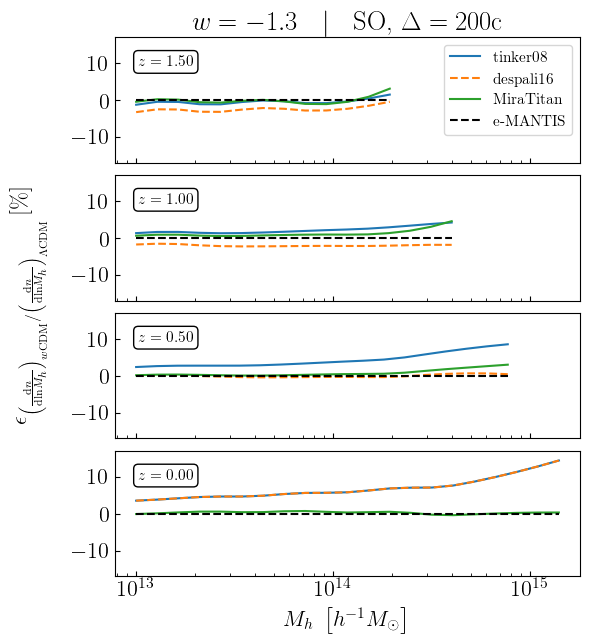

In [13]:
ncolor = 10
cmap=plt.get_cmap(f'tab{ncolor}')

nbins_per_decade = 10

deltac = 200
w_value = -1.3

fig, axes = plt.subplots(len(z_list), 1, gridspec_kw={'hspace': 0.1, 'wspace':0}, sharex="all", sharey=True, figsize=(6,7))

for i,z in enumerate(z_list):

    massmin = emu_hmf[deltac].range("mass_halo", aexp=aexp_list[i])[0]
    massmax = emu_hmf[deltac].range("mass_halo", aexp=aexp_list[i])[1]
    nbins = int(np.round(np.log10(massmax/massmin)*nbins_per_decade))
    bins = np.geomspace(massmin, massmax, nbins)

    emantis_hmf_ref, emantis_std_ref = emu_hmf[deltac].predict_hmf(bins, cosmo_params_planck18, aexp_list[i], True)

    params_emantis_wcdm = copy.deepcopy(cosmo_params_planck18)
    params_emantis_wcdm["w"] = w_value
    emantis_hmf_wcdm, emantis_std_wcdm = emu_hmf[deltac].predict_hmf(bins, params_emantis_wcdm, aexp_list[i], True)

    emantis_boost = emantis_hmf_wcdm / emantis_hmf_ref

    params_colossus_lcdm = {'flat': True,
                        'H0': cosmo_params_planck18["h"]*100,
                        'Om0': cosmo_params_planck18["Omega_m"],
                        'Ob0': cosmo_params_planck18["Omega_b"],
                        'sigma8': cosmo_params_planck18["sigma8"],
                        'ns': cosmo_params_planck18["n_s"],
                        'w0': cosmo_params_planck18["w"],
                        'de_model': 'w0'
                      }

    params_colossus_wcdm = {'flat': True,
                        'H0': cosmo_params_planck18["h"]*100,
                        'Om0': cosmo_params_planck18["Omega_m"],
                        'Ob0': cosmo_params_planck18["Omega_b"],
                        'sigma8': cosmo_params_planck18["sigma8"],
                        'ns': cosmo_params_planck18["n_s"],
                        'w0': w_value,
                        'de_model': 'w0'
                      }

    hmf_fit_boost = {}
    c = 0
    for j,name in enumerate(fits_names):
        # Maximum redshift for crocce10.
        if (name == 'bocquet16') and (z>0):
            axes[i].plot(np.NaN, np.NaN, '-', color=cmap(c%ncolor), label=name)
            c += 1
            continue
            
        mdef = f'{deltac}c'
    
        cosmo = cosmology.setCosmology('myCosmo', **params_colossus_lcdm)
        hmf_fit_lcdm = mass_function.massFunction(bins, z, mdef = mdef, model = name, q_out = 'dndlnM')
        cosmo = cosmology.setCosmology('myCosmo', **params_colossus_wcdm)
        hmf_fit_wcdm = mass_function.massFunction(bins, z, mdef = mdef, model = name, q_out = 'dndlnM')
        hmf_fit_boost[name] = hmf_fit_wcdm / hmf_fit_lcdm
        if (name == "despali16"):
            axes[i].plot(bins, (hmf_fit_boost[name] - emantis_boost) / emantis_boost * 100, '--', color=cmap(c%ncolor), label=name)
        else:
            axes[i].plot(bins, (hmf_fit_boost[name] - emantis_boost) / emantis_boost * 100, color=cmap(c%ncolor), label=name)
        c += 1

    if (w_value >= -1.3) and (w_value <= -0.7):
        params_mt_ref = {'Ommh2': cosmo_params_planck18["Omega_m"]*cosmo_params_planck18["h"]**2,
                'Ombh2': cosmo_params_planck18["Omega_b"]*cosmo_params_planck18["h"]**2,
                'Omnuh2': 0,
                'n_s': cosmo_params_planck18["n_s"],
                'h': cosmo_params_planck18["h"],
                'w_0': cosmo_params_planck18["w"],
                'w_a': 0,
                'sigma_8': cosmo_params_planck18["sigma8"]}
        
        hmf_mt_ref = MiraTitanEmu.predict(params_mt_ref, z, bins)[0][0] 
    
        params_mt = {'Ommh2': cosmo_params_planck18["Omega_m"]*cosmo_params_planck18["h"]**2,
                    'Ombh2': cosmo_params_planck18["Omega_b"]*cosmo_params_planck18["h"]**2,
                    'Omnuh2': 0,
                    'n_s': cosmo_params_planck18["n_s"],
                    'h': cosmo_params_planck18["h"],
                    'w_0': w_value,
                    'w_a': 0,
                    'sigma_8': cosmo_params_planck18["sigma8"]}
        
        hmf_mt = MiraTitanEmu.predict(params_mt, z, bins)[0][0] 
    
        hmf_mt_boost = hmf_mt / hmf_mt_ref
        axes[i].plot(bins, (hmf_mt_boost - emantis_boost) / emantis_boost * 100, color=cmap(c%ncolor), label='MiraTitan')

    axes[i].plot(bins, [0 for elt in bins], '--k', label='e-MANTIS')
    
    textstr = '\n'.join((
    f'$z={z:.2f}$',))
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=1)
    # place a text box in top left in axes coords
    axes[i].text(0.05, 0.75, textstr, transform=axes[i].transAxes, fontsize=11,
    verticalalignment='bottom', bbox=props)
    
axes[-1].set_xlabel(r'$M_{h} \ \left[h^{-1}M_\odot\right]$')
fig.text(-0.05, 0.5, r'$\epsilon_{\left(\frac{\mathrm{d}n}{\mathrm{dln}M_{h}}\right)_{w\mathrm{CDM}} / \left(\frac{\mathrm{d}n}{\mathrm{dln}M_{h}}\right)_{\Lambda\mathrm{CDM}}} \left[\%\right]$', va='center', rotation='vertical')

axes[-1].set_xscale('log')

axes[-1].set_ylim((-17, 17))
axes[0].legend(fontsize=11)

if deltac == 'fof':
    axes[0].set_title(fr'$w={w_value} \quad | \quad$FoF, $b = 0.2$')
    plt.tight_layout()
else:
    axes[0].set_title(fr'$w={w_value} \quad | \quad$SO, $\Delta = {deltac}\mathrm{{c}}$')
    plt.tight_layout()

plt.show()

In [14]:
# Load emantis emulators.
emu_s_median = Emantis("sparsity_nocorr", "wCDM", stat="median", delta1=200, delta2=500)
emu_s_std = Emantis("sparsity_nocorr", "wCDM", stat="std", delta1=200, delta2=500)

emu_spt_median = Emantis("sparsity_nocorr", "wCDM", stat="pt_median", delta1=200, delta2=500)
emu_spt_std = Emantis("sparsity_nocorr", "wCDM", stat="pt_std", delta1=200, delta2=500)
emu_spt_lambda = Emantis("sparsity_nocorr", "wCDM", stat="pt_lambda", delta1=200, delta2=500)

NameError: name 'Emantis' is not defined

In [ ]:
# Mean sparsity vs redshift

for i,z in enumerate(z_raygal):
    # Select mass bin.
    massmin = 1e13
    massmax = 1e14
    cond_m = (masses_raygal[z][200] >= massmin) & (masses_raygal[z][200] <= massmax)
    m200_bin = masses_raygal[z][200][cond_m]
    m500_bin = masses_raygal[z][500][cond_m]

    # Compute RayGal sparsities.
    sbin = m200_bin/m500_bin
    smedian = np.median(sbin)
    #sstd = np.std(sbin, ddof=1)
    sstd = biweight_scale(sbin)

    # Plot RayGal sparsities.
    if i == 0:
        plt.errorbar(z, smedian, sstd, marker = 'd', color = 'k', label=r'RayGal $\Lambda\mathrm{CDM}$')
    else:
        plt.errorbar(z, smedian, sstd, marker = 'd', color = 'k')

    # Compute emantis predictions.
    smedian_emu = quad(lambda x: emu_s_median.predict(x, cosmo_params_raygal_lcdm, aexp_raygal[i])[0], massmin, massmax)[0] / (massmax - massmin)
    sstd_emu = quad(lambda x: emu_s_std.predict(x, cosmo_params_raygal_lcdm, aexp_raygal[i])[0], massmin, massmax)[0] / (massmax - massmin)

    # Plot emantis predictions.
    if i == 0:
        plt.errorbar(z, smedian_emu, sstd_emu, marker = 'o', color = 'r', label='e-MANTIS')
    else:
        plt.errorbar(z, smedian_emu, sstd_emu, marker = 'o', color = 'r')

plt.xlabel(r"$z$")
plt.ylabel(r"$\left<s_{200,500}\right>$")
plt.title(r"$10^{13} < M_{200c} < 10^{14}$")
plt.grid(True, linestyle='--')
plt.legend()
plt.show()

In [ ]:
# First and second moment as a function of mass.
ncolor = 10
cmap=plt.get_cmap(f'tab{ncolor}')
for i,z in enumerate(z_raygal):
    # Define mass bins.
    nbins = 10
    massmin = 1e13
    massmax = emu_s_median.range("mass_halo", aexp=aexp_raygal[i])[1]
    bin_edges = np.geomspace(massmin, massmax, nbins + 1)

    # Compute RayGal data.
    s_raygal = masses_raygal[z][200]/masses_raygal[z][500]
    s_median, bin_edges, _ = binned_statistic(masses_raygal[z][200],
                                s_raygal,
                                statistic=np.median,
                                bins=bin_edges)
    bins = 0.5*(bin_edges[:-1]+bin_edges[1:])

    # Plot RayGal data.
    plt.plot(bins, s_median, color=cmap(i%20), label=fr'$z={z:.2f}$')

    # Get emantis predictions.
    s_median_emantis = emu_s_median.predict(bins, cosmo_params_raygal_lcdm, aexp_raygal[i])

    # Plot emantis predictions
    plt.plot(bins, s_median_emantis, '--', color=cmap(i%20))
    
plt.xscale('log')
plt.xlabel(r'$M_{200c} \ \left[h^{-1}M_\odot\right]$')
plt.ylabel(r'$\mu_{s_{200,500}}$')

plt.legend()
plt.grid(True, linestyle='--')
plt.show()

In [ ]:
# First and second moment as a function of mass.

for i,z in enumerate(z_raygal):
    # Define mass bins.
    nbins = 10
    massmin = 1e13
    massmax = emu_s_std.range("mass_halo", aexp=aexp_raygal[i])[1]
    bin_edges = np.geomspace(massmin, massmax, nbins + 1)

    # Compute RayGal data.
    s_raygal = masses_raygal[z][200]/masses_raygal[z][500]
    s_std, bin_edges, _ = binned_statistic(masses_raygal[z][200],
                                s_raygal,
                                statistic = biweight_scale,
                                bins = bin_edges)
    bins = 0.5*(bin_edges[:-1]+bin_edges[1:])

    # Plot RayGal data.
    plt.plot(bins, s_std, color=cmap(i%20), label=fr"$z={z:.2f}$")

    # Get emantis predictions.
    s_std_emantis = emu_s_std.predict(bins, cosmo_params_raygal_lcdm, aexp_raygal[i])

    # Plot emantis predictions
    plt.plot(bins, s_std_emantis, '--', color=cmap(i%20))
    
plt.xscale('log')
plt.xlabel(r'$M_{200c} \ \left[h^{-1}M_\odot\right]$')
plt.ylabel(r'$\sigma_{s_{200,500}}$')

plt.legend()
plt.grid(True, linestyle='--')
plt.show()

In [ ]:
# 1D sparsity PDF.

dlnM = 0.1
m0 = 7e13

nbins = 100
smin = 1.001
smax = 2.5
sbin_edges = np.geomspace(smin, smax, nbins+1)
sbin_centres = 0.5*(sbin_edges[1:] + sbin_edges[:-1])

for i,z in enumerate(z_raygal):
    cond_m = (masses_raygal[z][200] >= m0 - m0*dlnM) & (masses_raygal[z][200] <= m0 + m0*dlnM)
    m200_bin = masses_raygal[z][200][cond_m]
    m500_bin = masses_raygal[z][500][cond_m]

    # Compute RayGal sparsities.
    sbin = m200_bin/m500_bin

    hist, edges = np.histogram(sbin, bins=sbin_edges, density=True)
    plt.plot(sbin_centres, hist, 'k', label=r'RayGal $\Lambda\mathrm{CDM}$')

    # Get emantis predictions.
    spt_lambda = emu_spt_lambda.predict(m0, cosmo_params_raygal_lcdm, aexp_raygal[i])
    spt_median = emu_spt_median.predict(m0, cosmo_params_raygal_lcdm, aexp_raygal[i])
    spt_std = emu_spt_std.predict(m0, cosmo_params_raygal_lcdm, aexp_raygal[i])

    # Get sparsity PDF.
    s_pdf = halo_profiles.sparsity_pdf_from_powertransform(spt_median[0],
                                                           spt_std[0],
                                                           spt_lambda[0])
    pdf_pred = s_pdf(sbin_centres)
    plt.plot(sbin_centres, pdf_pred, '--r', label='e-MANTIS')

    plt.fill_between(sbin_centres, hist, pdf_pred, color='r', alpha=0.5)
    

    plt.xlabel(r"$s_{200,500}$")
    plt.ylabel(r"$\rho\left(s_{200,500}|M_{200c}\right)$")
    plt.ylim((-0.05, 4.5))
    plt.grid(True, linestyle='--')
    plt.title(fr'$z={z:.2f} \quad | \quad M_{{200c}} =1\cdot10^{{14}} h^{{-1}}M_\odot$')
    plt.legend()
    plt.show()

    pdf_norm = quad(lambda x: s_pdf(x)[0], 0, 100)
    print(f"Predicted PDF norm: {pdf_norm[0]} (rel. err: {pdf_norm[1]/pdf_norm[0]:.2e}).")